In [1]:
%matplotlib inline
from astropy.table import Table, Column
from astropy.io import fits
from tqdm.notebook import tqdm
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import shutil
import subprocess

In [2]:
sys.path.append('/home/aalvarez/Work/Projects/Elements/5.8/InstallArea/x86_64-fc31-gcc92-dbg/python/')
sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/NNPZ/python/')
os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/NNPZ/auxdir/'
os.environ['PATH'] = os.environ['PATH'] + ':/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/build.x86_64-fc31-gcc92-dbg/scripts/'

In [3]:
from nnpz.photometry import *
from nnpz.reference_sample.ReferenceSample import ReferenceSample
from nnpz.program import BuildPhotometry

# Reference and target samples

Got `NNPZ_filter_shift_valid_20Feb20.fits`

In [4]:
ref_catalog = Table.read('/home/aalvarez/Work/Data/WillHartley/NNPZ_filter_shift_test_sample_10Mar20.fits')

# Compare

## Prepare the photometry computation

In [5]:
class SedProvider(object):
    def __init__(self, basedir):
        self.__basedir = basedir
        self.__cache = dict()
        
    def get_sed(self, name):
        if name not in self.__cache:
            self.__cache[name] = np.genfromtxt(os.path.join(self.__basedir, name))
        return self.__cache[name]

In [6]:
filter_provider = DirectoryFilterProvider('/home/aalvarez/Work/Data/WillHartley/DC3')
sed_provider = SedProvider('/home/aalvarez/Phosphoros/AuxiliaryData/SEDs/')

In [7]:
transmissions = dict()
for filter_name in filter_provider.getFilterNames():
    print(f'Loading {filter_name}')
    transmissions[filter_name] = filter_provider.getFilterTransmission(filter_name)
filters = transmissions.keys()

Loading J
Loading r
Loading z
Loading g
Loading i
Loading Y
Loading u
Loading vis
Loading H


In [8]:
for f in transmissions:
    print(f'Correcting {f}')
    ref_catalog[f'Flux_{f}'] -= ref_catalog[f'Fluxshift_{f}']

Correcting J
Correcting r
Correcting z
Correcting g
Correcting i
Correcting Y
Correcting u
Correcting vis
Correcting H


In [9]:
ref_catalog.write('/home/aalvarez/Work/Data/WillHartley/Unshifted.fits', overwrite=True)

In [10]:
photo_calc = PhotometryCalculator(transmissions, FnuuJyPrePostProcessor())

In [11]:
def redshift_sed(row):
    original_sed = sed_provider.get_sed(row['SED_name'])
    sed = original_sed.copy()
    sed[:, 0] *= (1 + row['z'])
    sed[:, 1] /= (1 + row['z'])**2
    return sed
    
def compute_photometry(row):
    sed = redshift_sed(row)
    # Compute "raw" photometries
    fluxes = photo_calc.compute(sed)
    # Compute scale factor using vis band
    scale_factor = row['Flux_vis'] / fluxes['vis']
    sed[:, 1] *= scale_factor        
    # Recompute with the scaled SED
    fluxes = photo_calc.compute(sed)
    return sed, fluxes, scale_factor

# Check photometries

In [12]:
recomputed = np.zeros(len(ref_catalog), dtype=[(f'nnpz_{f}', np.float) for f in filters] + [('ID', np.int64)])

for i in tqdm(range(len(ref_catalog))):
    row = ref_catalog[i]
    sed, fluxes, scale_factor = compute_photometry(row)   
    recomputed[i]['ID'] = row['ID']
    for f in filters:
        recomputed[i][f'nnpz_{f}'] = fluxes[f]

# Sanity check

In [13]:
assert (recomputed['ID'] == ref_catalog['ID']).all()

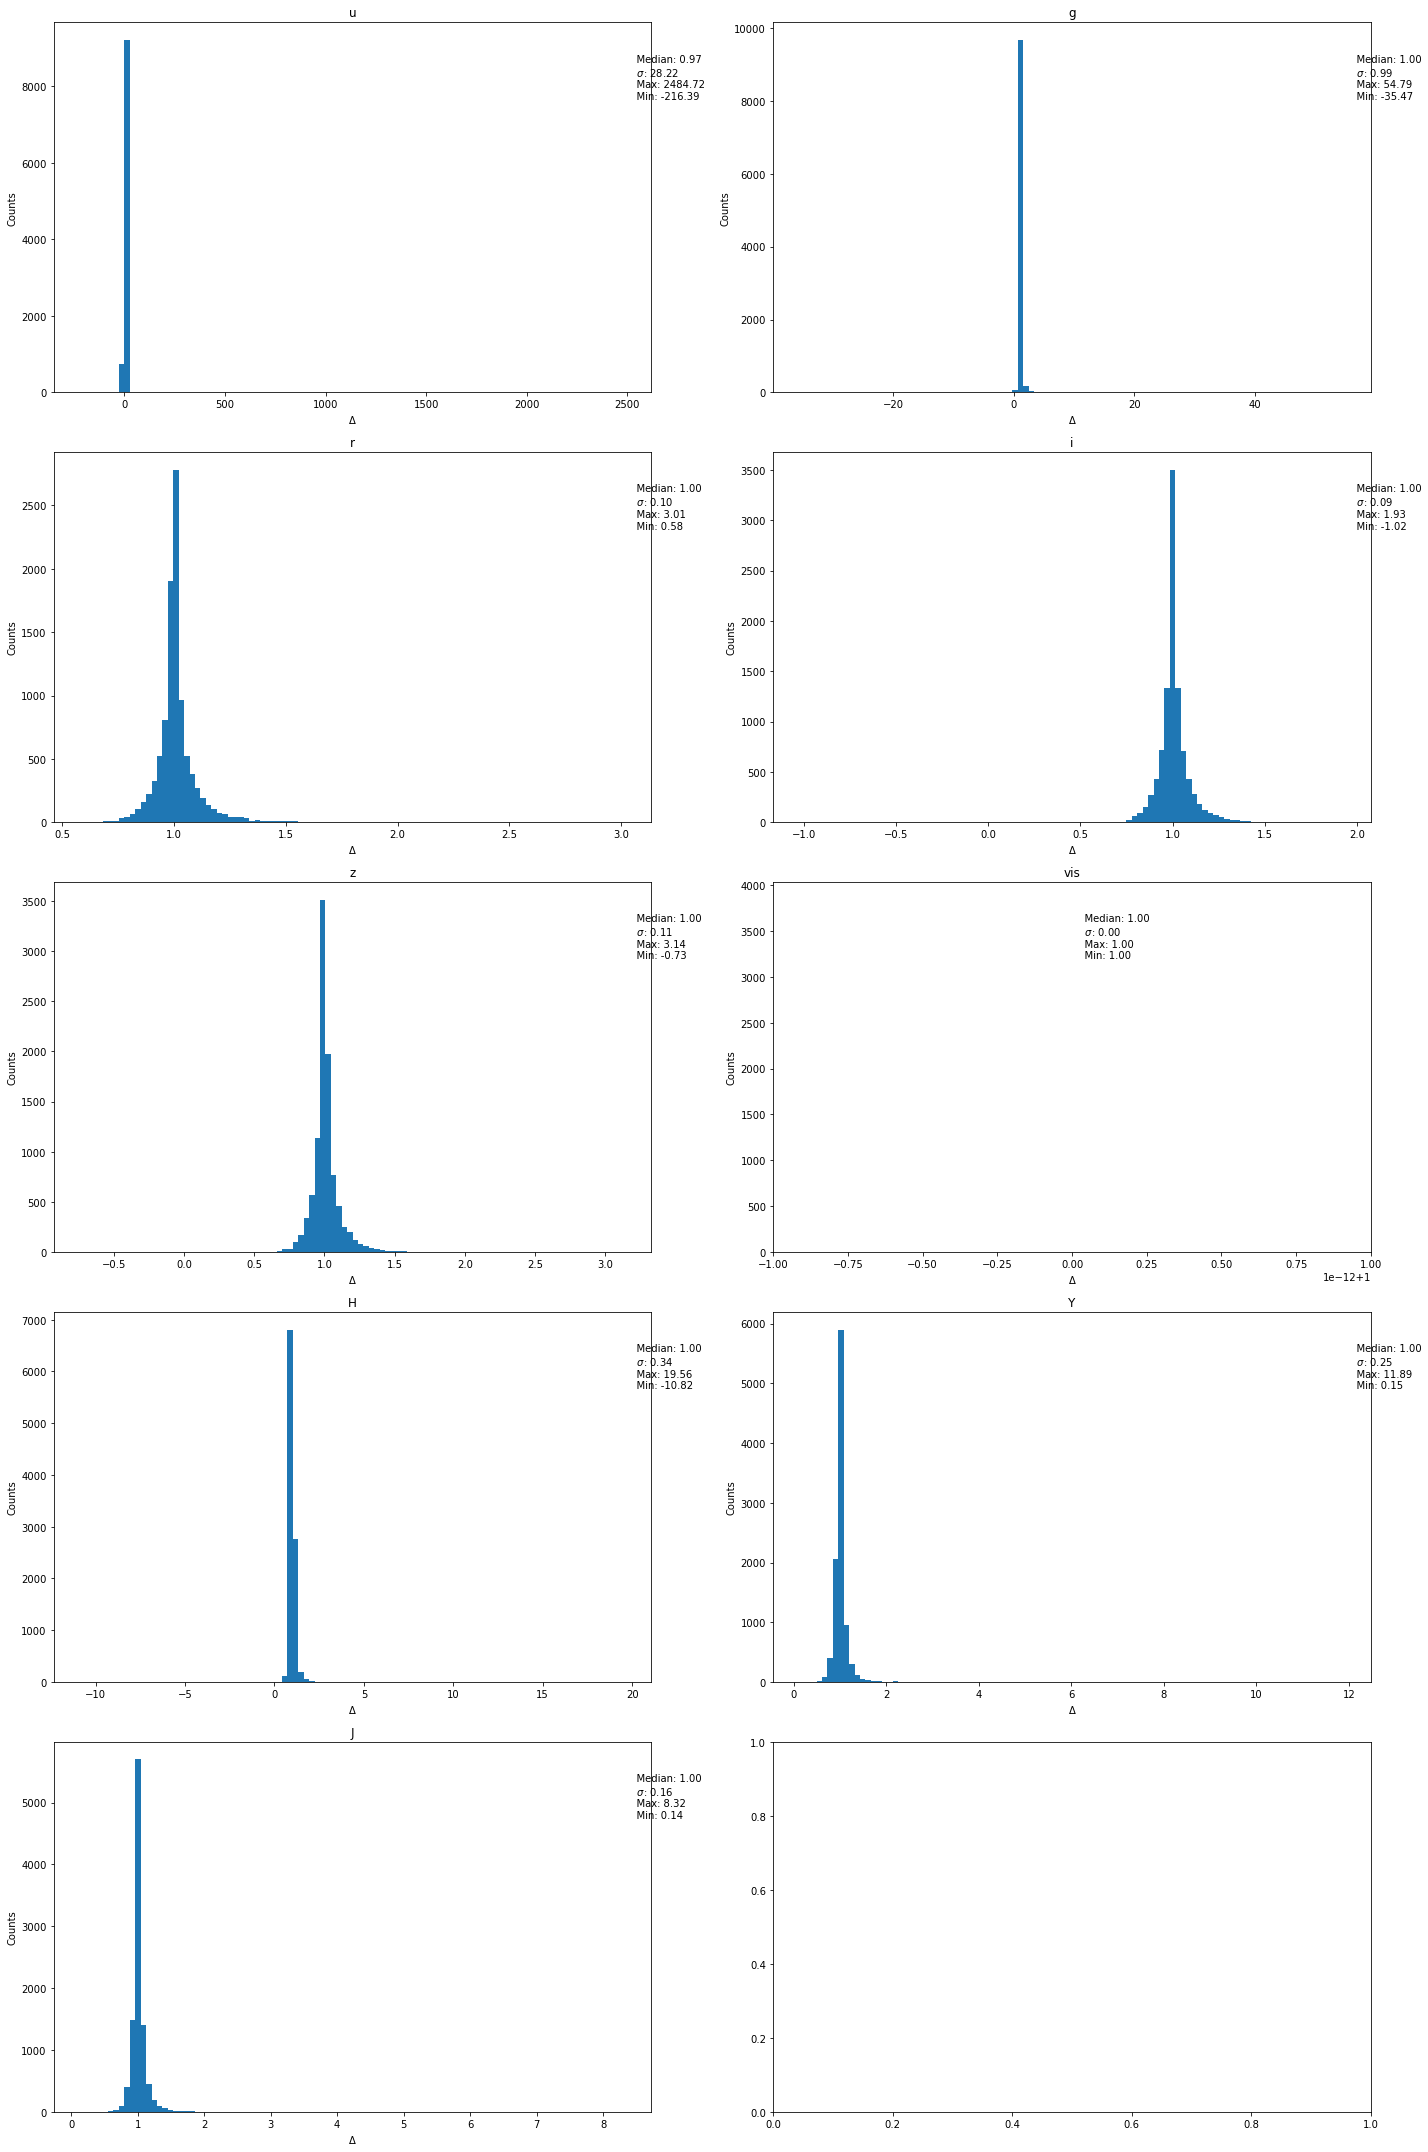

In [14]:
nfilters = len(transmissions)
ncols = 2
nrows = int(np.ceil(nfilters / ncols))

filters = ['u', 'g', 'r', 'i', 'z', 'vis', 'H', 'Y', 'J']

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))
axes = axes.ravel()

for i, filter_name in enumerate(filters):
    ax = axes[i]
    wfn = f'Flux_{filter_name}'
    
    diff = recomputed[f'nnpz_{filter_name}'] / ref_catalog[wfn]
    
    counts, _, _ = ax.hist(diff, bins=100)
    ax.text(diff.max(), np.max(counts)*0.80, f"""
    Median: {np.median(diff):.2f}
    $\sigma$: {np.std(diff):.2f}
    Max: {np.max(diff):.2f}
    Min: {np.min(diff):.2f}
    """)
    ax.set_title(filter_name)
    ax.set_xlabel('$\Delta$')
    ax.set_ylabel('Counts')
plt.tight_layout()
plt.show()

In [15]:
sample_idxs = np.random.choice(len(ref_catalog), 10000)
will_sample = ref_catalog[sample_idxs]
nnpz_sample = recomputed[sample_idxs]
assert((will_sample['ID'] == nnpz_sample['ID']).all())

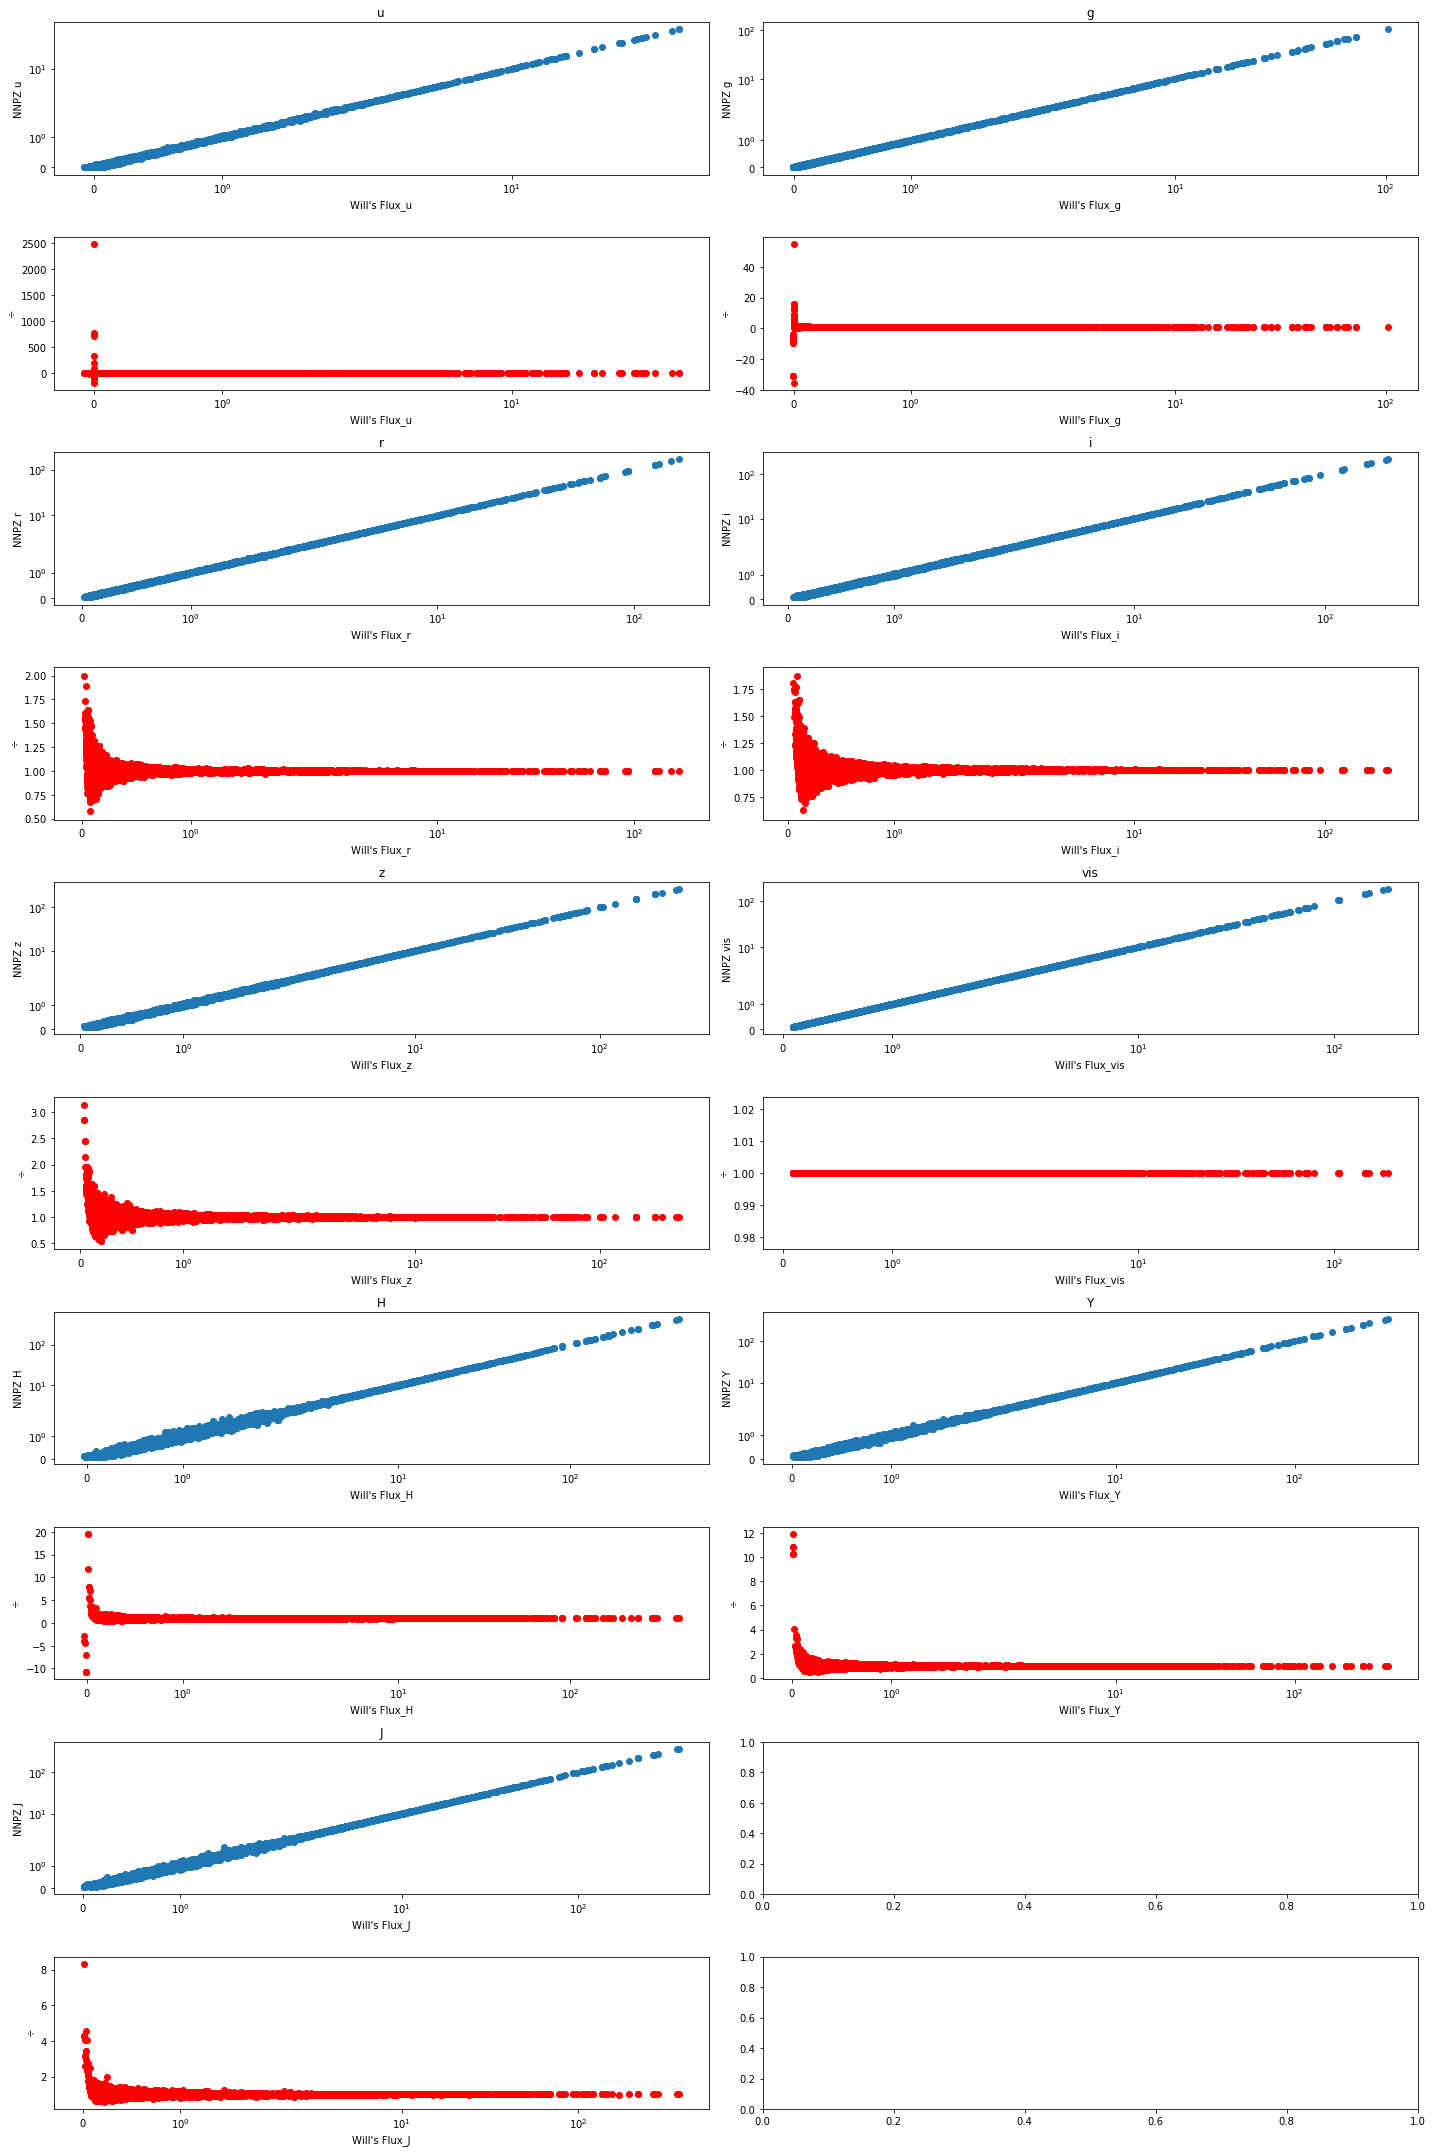

In [16]:
nfilters = len(filters)
ncols = 2
nrows = int(np.ceil(nfilters / ncols)) * 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))

for i, filter_name in enumerate(filters):
    ax = axes[(i//2) * 2, i % 2]
    wfn = f'Flux_{filter_name}'
    ax.scatter(will_sample[wfn], nnpz_sample[f'nnpz_{filter_name}'])
    ax.set_title(filter_name)
    ax.set_xlabel(f'Will\'s {wfn}')
    ax.set_ylabel(f'NNPZ {filter_name}')
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    
    ax2 = axes[(i//2) * 2 + 1, i % 2]
    ax2.scatter(will_sample[wfn], nnpz_sample[f'nnpz_{filter_name}']/will_sample[wfn], c='r')
    #ax2.plot([0, np.max(will_sample[wfn])], [1, 1], c='grey', linestyle='--')
    ax2.set_xscale('symlog')
    #ax2.set_yscale('symlog')
    #ax2.set_ylim(0.99,1.01)
    ax2.set_ylabel('$\div$')
    ax2.set_xlabel(f'Will\'s {wfn}')
    
plt.tight_layout()
plt.show()

In [17]:
_, will_sample['SED_id'] = np.unique(will_sample['SED_name'], return_inverse=True)

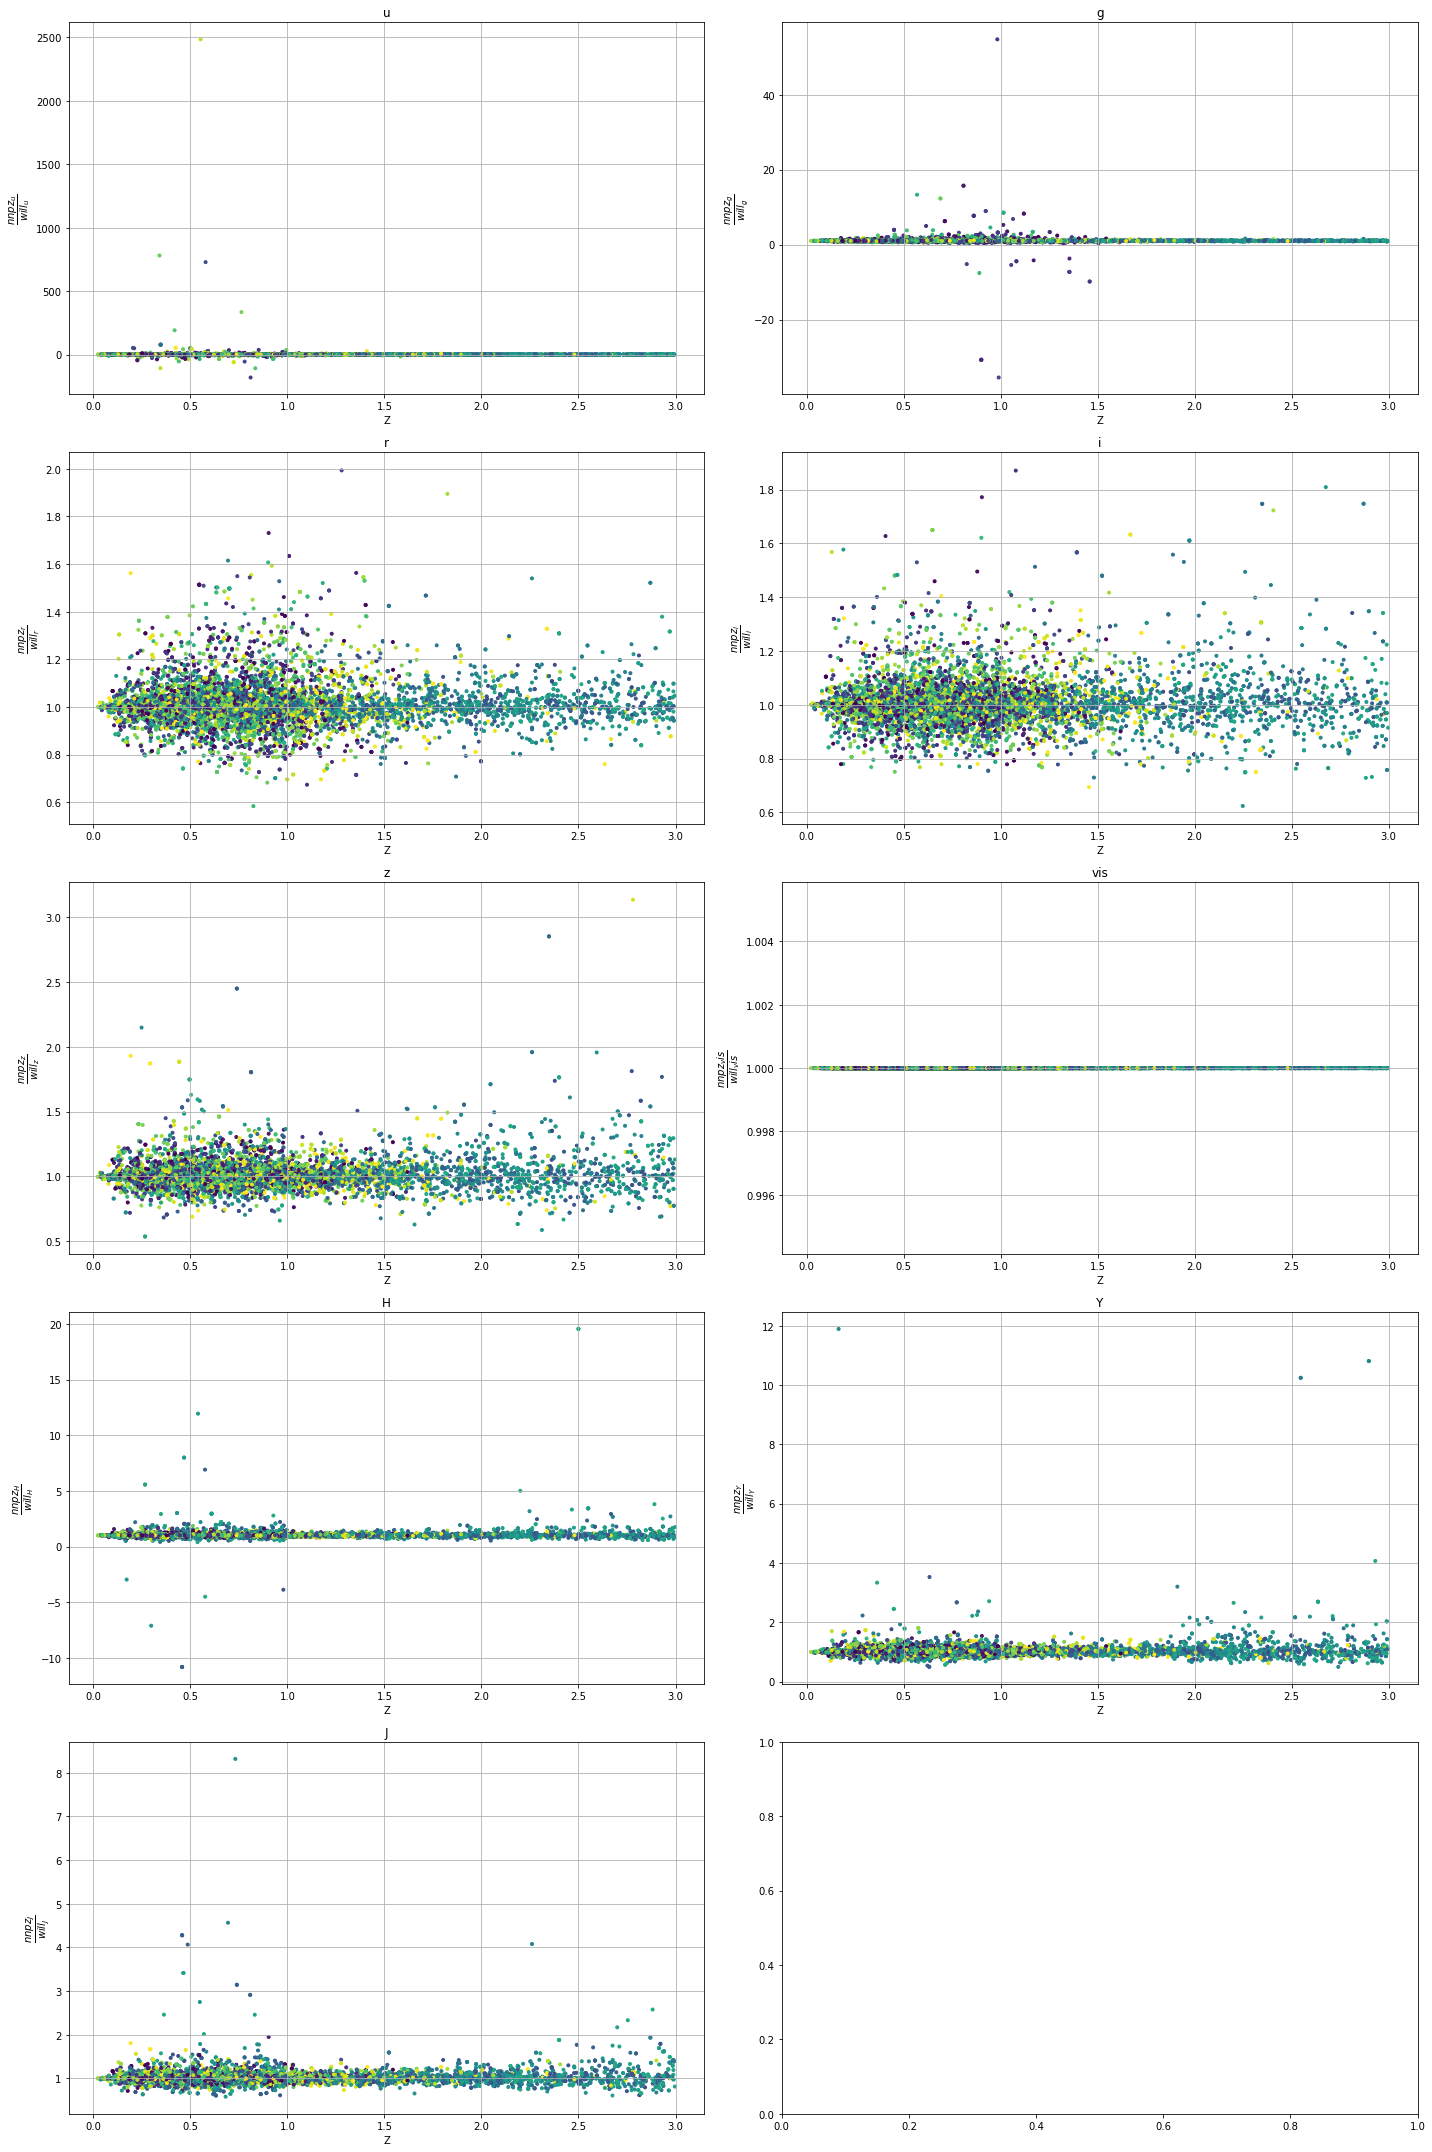

In [18]:
nfilters = len(filters)
ncols = 2
nrows = int(np.ceil(nfilters / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))

axes = np.ravel(axes)

for i, filter_name in enumerate(filters):
    ax = axes[i]
    wfn = f'Flux_{filter_name}'
    ax.scatter(will_sample['z'], nnpz_sample[f'nnpz_{filter_name}']/will_sample[wfn], marker='.', c=will_sample['SED_id'])
    ax.set_title(filter_name)
    ax.set_xlabel('Z')
    ax.set_ylabel(f'$\\dfrac{{nnpz_{filter_name}}}{{will_{filter_name}}}$')
    ax.grid(True)
    
plt.tight_layout()
plt.show()